In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from skimage.measure import regionprops_table

In [2]:
from stardist.models import StarDist2D
from csbdeep.utils import normalize

2022-10-31 16:38:53.949294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 16:38:54.156900: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-31 16:38:54.968524: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-31 16:38:54.968637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: 

In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2022-10-31 16:38:58.742987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-31 16:38:58.743024: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

In [4]:
key = '1X_trimmed'

#### load data

In [62]:
sample = 'HT434P1-S1H3U1'
a = sc.read_h5ad(f'../data/pdac/{sample}/adata.h5ad')
a

AnnData object with n_obs × n_vars = 3018 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

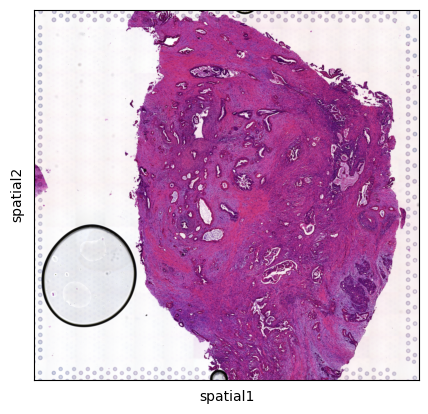

In [63]:
sc.pl.spatial(a)

In [64]:
a.uns['rescaled_he'].keys()

dict_keys(['16X_notrim', '16X_trimmed', '1X_notrim', '1X_trimmed', '2X_notrim', '2X_trimmed', '4X_notrim', '4X_trimmed', '512x512_notrim', '512x512_trimmed', '8X_notrim', '8X_trimmed'])

In [65]:
hires_he_img = a.uns['rescaled_he'][key]
hires_he_img.shape

(15914, 16555, 3)

In [66]:
img = sq.im.ImageContainer(hires_he_img, layer="image")

#### segmentation

In [67]:
StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


StarDist2D(2D_versatile_he): YXC → YXC
├─ Directory: None
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 3], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[512, 512], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.1], train_class_weights=(1, 1), train_epochs=200, train_steps_per_epoch=200, train_learning_rate=0.0003, train_batch_size=8, train_n_val_patches=3, train_tensorboard=True, train_r

In [68]:
def stardist_2D_versatile_he(img, nms_thresh=None, prob_thresh=None):
    #axis_norm = (0,1)   # normalize channels independently
    axis_norm = (0,1,2) # normalize channels jointly
    # Make sure to normalize the input image beforehand or supply a normalizer to the prediction function.
    # this is the default normalizer noted in StarDist examples.
    img = normalize(img, 1, 99.8, axis=axis_norm)
    model = StarDist2D.from_pretrained('2D_versatile_he')
    labels, _ = model.predict_instances(img, n_tiles=(10, 10, 1), nms_thresh=nms_thresh, prob_thresh=prob_thresh)
    return labels

In [69]:
model = StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [70]:
%%time
sq.im.segment(
    img=img,
    layer="image",
    channel=None,
    method=stardist_2D_versatile_he,
    layer_added='segmented_stardist_default',
    prob_thresh=.2,
    nms_thresh=None
)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
1/1 [==============================] - 0s 40ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 1s 555ms/step


  1%|          | 1/100 [00:00<01:13,  1.36it/s]

1/1 [==============================] - 0s 397ms/step


  2%|▏         | 2/100 [00:01<01:00,  1.62it/s]

1/1 [==============================] - 0s 410ms/step


  3%|▎         | 3/100 [00:01<00:57,  1.70it/s]

1/1 [==============================] - 0s 406ms/step


  4%|▍         | 4/100 [00:02<00:55,  1.73it/s]

1/1 [==============================] - 0s 402ms/step


  5%|▌         | 5/100 [00:02<00:54,  1.76it/s]

1/1 [==============================] - 0s 398ms/step


  6%|▌         | 6/100 [00:03<00:53,  1.76it/s]

1/1 [==============================] - 0s 401ms/step


  7%|▋         | 7/100 [00:04<00:52,  1.77it/s]

1/1 [==============================] - 0s 401ms/step


  8%|▊         | 8/100 [00:04<00:51,  1.80it/s]

1/1 [==============================] - 0s 396ms/step


  9%|▉         | 9/100 [00:05<00:49,  1.83it/s]

1/1 [==============================] - 0s 406ms/step


 10%|█         | 10/100 [00:05<00:49,  1.83it/s]

1/1 [==============================] - 0s 414ms/step


 11%|█         | 11/100 [00:06<00:49,  1.79it/s]

1/1 [==============================] - 0s 414ms/step


 12%|█▏        | 12/100 [00:06<00:48,  1.80it/s]

1/1 [==============================] - 0s 407ms/step


 13%|█▎        | 13/100 [00:07<00:48,  1.80it/s]

1/1 [==============================] - 0s 405ms/step


 14%|█▍        | 14/100 [00:07<00:47,  1.79it/s]

1/1 [==============================] - 0s 410ms/step


 15%|█▌        | 15/100 [00:08<00:48,  1.76it/s]

1/1 [==============================] - 0s 403ms/step


 16%|█▌        | 16/100 [00:09<00:47,  1.76it/s]

1/1 [==============================] - 0s 413ms/step


 17%|█▋        | 17/100 [00:09<00:47,  1.76it/s]

1/1 [==============================] - 0s 396ms/step


 18%|█▊        | 18/100 [00:10<00:46,  1.76it/s]

1/1 [==============================] - 0s 398ms/step


 19%|█▉        | 19/100 [00:10<00:45,  1.76it/s]

1/1 [==============================] - 0s 401ms/step


 20%|██        | 20/100 [00:11<00:44,  1.78it/s]

1/1 [==============================] - 0s 415ms/step


 21%|██        | 21/100 [00:11<00:45,  1.75it/s]

1/1 [==============================] - 0s 404ms/step


 22%|██▏       | 22/100 [00:12<00:43,  1.78it/s]

1/1 [==============================] - 0s 394ms/step


 23%|██▎       | 23/100 [00:13<00:43,  1.78it/s]

1/1 [==============================] - 0s 391ms/step


 24%|██▍       | 24/100 [00:13<00:42,  1.77it/s]

1/1 [==============================] - 0s 395ms/step


 25%|██▌       | 25/100 [00:14<00:42,  1.75it/s]

1/1 [==============================] - 0s 400ms/step


 26%|██▌       | 26/100 [00:14<00:42,  1.76it/s]

1/1 [==============================] - 0s 398ms/step


 27%|██▋       | 27/100 [00:15<00:41,  1.75it/s]

1/1 [==============================] - 0s 391ms/step


 28%|██▊       | 28/100 [00:15<00:41,  1.73it/s]

1/1 [==============================] - 0s 408ms/step


 29%|██▉       | 29/100 [00:16<00:41,  1.70it/s]

1/1 [==============================] - 0s 417ms/step


 30%|███       | 30/100 [00:17<00:41,  1.70it/s]

1/1 [==============================] - 0s 416ms/step


 31%|███       | 31/100 [00:17<00:40,  1.70it/s]

1/1 [==============================] - 0s 403ms/step


 32%|███▏      | 32/100 [00:18<00:39,  1.74it/s]

1/1 [==============================] - 0s 408ms/step


 33%|███▎      | 33/100 [00:18<00:38,  1.76it/s]

1/1 [==============================] - 0s 421ms/step


 34%|███▍      | 34/100 [00:19<00:38,  1.71it/s]

1/1 [==============================] - 0s 403ms/step


 35%|███▌      | 35/100 [00:20<00:38,  1.70it/s]

1/1 [==============================] - 0s 406ms/step


 36%|███▌      | 36/100 [00:20<00:37,  1.71it/s]

1/1 [==============================] - 0s 409ms/step


 37%|███▋      | 37/100 [00:21<00:36,  1.71it/s]

1/1 [==============================] - 0s 396ms/step


 38%|███▊      | 38/100 [00:21<00:36,  1.72it/s]

1/1 [==============================] - 0s 401ms/step


 39%|███▉      | 39/100 [00:22<00:36,  1.68it/s]

1/1 [==============================] - 0s 397ms/step


 40%|████      | 40/100 [00:22<00:35,  1.70it/s]

1/1 [==============================] - 0s 398ms/step


 41%|████      | 41/100 [00:23<00:34,  1.73it/s]

1/1 [==============================] - 0s 399ms/step


 42%|████▏     | 42/100 [00:24<00:32,  1.76it/s]

1/1 [==============================] - 0s 396ms/step


 43%|████▎     | 43/100 [00:24<00:32,  1.77it/s]

1/1 [==============================] - 0s 388ms/step


 44%|████▍     | 44/100 [00:25<00:31,  1.76it/s]

1/1 [==============================] - 0s 402ms/step


 45%|████▌     | 45/100 [00:25<00:31,  1.75it/s]

1/1 [==============================] - 0s 405ms/step


 46%|████▌     | 46/100 [00:26<00:30,  1.74it/s]

1/1 [==============================] - 0s 409ms/step


 47%|████▋     | 47/100 [00:26<00:30,  1.74it/s]

1/1 [==============================] - 0s 412ms/step


 48%|████▊     | 48/100 [00:27<00:30,  1.70it/s]

1/1 [==============================] - 0s 414ms/step


 49%|████▉     | 49/100 [00:28<00:30,  1.67it/s]

1/1 [==============================] - 0s 399ms/step


 50%|█████     | 50/100 [00:28<00:29,  1.69it/s]

1/1 [==============================] - 0s 400ms/step


 51%|█████     | 51/100 [00:29<00:28,  1.71it/s]

1/1 [==============================] - 0s 414ms/step


 52%|█████▏    | 52/100 [00:29<00:27,  1.73it/s]

1/1 [==============================] - 0s 401ms/step


 53%|█████▎    | 53/100 [00:30<00:26,  1.75it/s]

1/1 [==============================] - 0s 396ms/step


 54%|█████▍    | 54/100 [00:31<00:26,  1.76it/s]

1/1 [==============================] - 0s 403ms/step


 55%|█████▌    | 55/100 [00:31<00:25,  1.78it/s]

1/1 [==============================] - 0s 406ms/step


 56%|█████▌    | 56/100 [00:32<00:24,  1.78it/s]

1/1 [==============================] - 0s 393ms/step


 57%|█████▋    | 57/100 [00:32<00:24,  1.74it/s]

1/1 [==============================] - 0s 408ms/step


 58%|█████▊    | 58/100 [00:33<00:24,  1.71it/s]

1/1 [==============================] - 0s 396ms/step


 59%|█████▉    | 59/100 [00:33<00:24,  1.71it/s]

1/1 [==============================] - 0s 395ms/step


 60%|██████    | 60/100 [00:34<00:23,  1.71it/s]

1/1 [==============================] - 0s 400ms/step


 61%|██████    | 61/100 [00:35<00:22,  1.73it/s]

1/1 [==============================] - 0s 407ms/step


 62%|██████▏   | 62/100 [00:35<00:21,  1.75it/s]

1/1 [==============================] - 0s 401ms/step


 63%|██████▎   | 63/100 [00:36<00:21,  1.75it/s]

1/1 [==============================] - 0s 406ms/step


 64%|██████▍   | 64/100 [00:36<00:20,  1.76it/s]

1/1 [==============================] - 0s 408ms/step


 65%|██████▌   | 65/100 [00:37<00:19,  1.76it/s]

1/1 [==============================] - 0s 402ms/step


 66%|██████▌   | 66/100 [00:37<00:19,  1.76it/s]

1/1 [==============================] - 0s 419ms/step


 67%|██████▋   | 67/100 [00:38<00:19,  1.71it/s]

1/1 [==============================] - 0s 404ms/step


 68%|██████▊   | 68/100 [00:39<00:18,  1.70it/s]

1/1 [==============================] - 0s 401ms/step


 69%|██████▉   | 69/100 [00:39<00:18,  1.66it/s]

1/1 [==============================] - 0s 398ms/step


 70%|███████   | 70/100 [00:40<00:17,  1.70it/s]

1/1 [==============================] - 0s 443ms/step


 71%|███████   | 71/100 [00:40<00:17,  1.69it/s]

1/1 [==============================] - 0s 406ms/step


 72%|███████▏  | 72/100 [00:41<00:16,  1.75it/s]

1/1 [==============================] - 0s 395ms/step


 73%|███████▎  | 73/100 [00:41<00:15,  1.78it/s]

1/1 [==============================] - 0s 403ms/step


 74%|███████▍  | 74/100 [00:42<00:14,  1.79it/s]

1/1 [==============================] - 0s 405ms/step


 75%|███████▌  | 75/100 [00:43<00:14,  1.77it/s]

1/1 [==============================] - 0s 401ms/step


 76%|███████▌  | 76/100 [00:43<00:13,  1.77it/s]

1/1 [==============================] - 0s 392ms/step


 77%|███████▋  | 77/100 [00:44<00:12,  1.77it/s]

1/1 [==============================] - 0s 394ms/step


 78%|███████▊  | 78/100 [00:44<00:12,  1.75it/s]

1/1 [==============================] - 0s 399ms/step


 79%|███████▉  | 79/100 [00:45<00:12,  1.72it/s]

1/1 [==============================] - 0s 410ms/step


 80%|████████  | 80/100 [00:45<00:11,  1.73it/s]

1/1 [==============================] - 0s 410ms/step


 81%|████████  | 81/100 [00:46<00:10,  1.73it/s]

1/1 [==============================] - 0s 398ms/step


 82%|████████▏ | 82/100 [00:47<00:10,  1.76it/s]

1/1 [==============================] - 0s 404ms/step


 83%|████████▎ | 83/100 [00:47<00:09,  1.78it/s]

1/1 [==============================] - 0s 400ms/step


 84%|████████▍ | 84/100 [00:48<00:08,  1.78it/s]

1/1 [==============================] - 0s 416ms/step


 85%|████████▌ | 85/100 [00:48<00:08,  1.75it/s]

1/1 [==============================] - 0s 424ms/step


 86%|████████▌ | 86/100 [00:49<00:08,  1.70it/s]

1/1 [==============================] - 0s 401ms/step


 87%|████████▋ | 87/100 [00:50<00:07,  1.70it/s]

1/1 [==============================] - 0s 406ms/step


 88%|████████▊ | 88/100 [00:50<00:07,  1.70it/s]

1/1 [==============================] - 0s 401ms/step


 89%|████████▉ | 89/100 [00:51<00:06,  1.71it/s]

1/1 [==============================] - 0s 408ms/step


 90%|█████████ | 90/100 [00:51<00:05,  1.74it/s]

1/1 [==============================] - 0s 416ms/step


 91%|█████████ | 91/100 [00:52<00:05,  1.74it/s]

1/1 [==============================] - 0s 395ms/step


 92%|█████████▏| 92/100 [00:52<00:04,  1.78it/s]

1/1 [==============================] - 0s 398ms/step


 93%|█████████▎| 93/100 [00:53<00:03,  1.81it/s]

1/1 [==============================] - 0s 406ms/step


 94%|█████████▍| 94/100 [00:53<00:03,  1.82it/s]

1/1 [==============================] - 0s 405ms/step


 95%|█████████▌| 95/100 [00:54<00:02,  1.80it/s]

1/1 [==============================] - 0s 407ms/step


 96%|█████████▌| 96/100 [00:55<00:02,  1.76it/s]

1/1 [==============================] - 0s 406ms/step


 97%|█████████▋| 97/100 [00:55<00:01,  1.74it/s]

1/1 [==============================] - 0s 397ms/step


 98%|█████████▊| 98/100 [00:56<00:01,  1.75it/s]

1/1 [==============================] - 0s 408ms/step


 99%|█████████▉| 99/100 [00:56<00:00,  1.76it/s]

1/1 [==============================] - 0s 398ms/step


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


CPU times: user 12h 51min 33s, sys: 2min 49s, total: 12h 54min 23s
Wall time: 21min 51s


In [71]:
x = np.asarray(img['segmented_stardist_default'].as_numpy().squeeze())

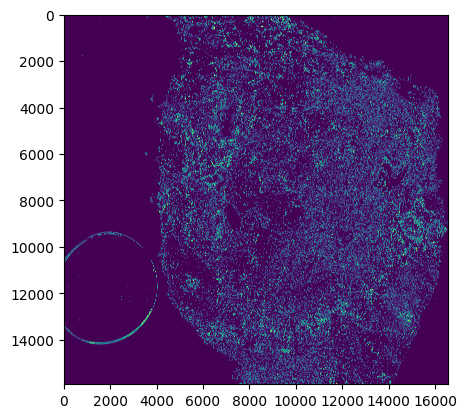

In [72]:
plt.imshow(x)

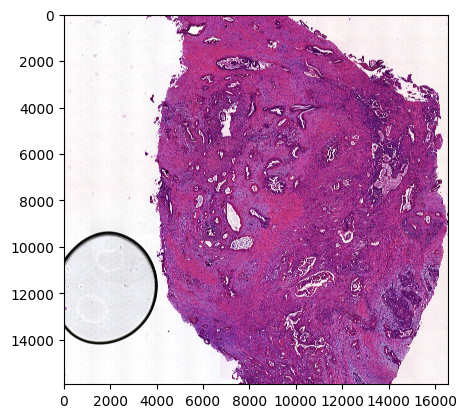

In [73]:
plt.imshow(hires_he_img)

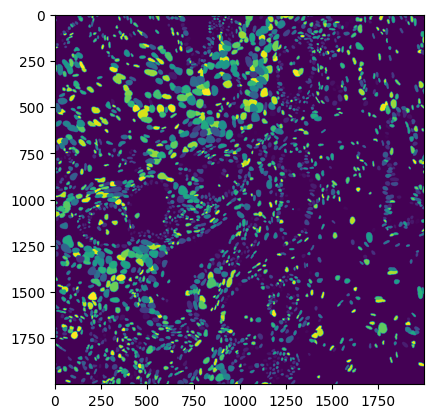

In [74]:
plt.imshow(x[6000:8000, 6000:8000])

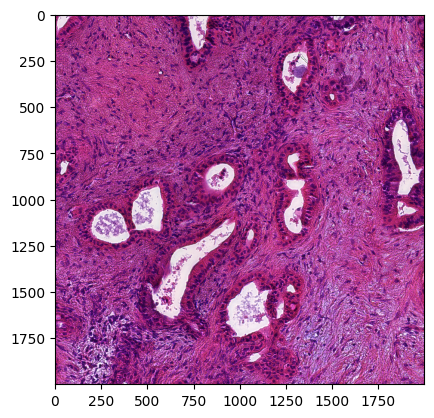

In [75]:
plt.imshow(hires_he_img[6000:8000, 6000:8000])

In [76]:
a.uns[f'nuclei_segmentation_{key}'] = x

In [77]:
props = regionprops_table(x, properties=('label', 'centroid'))
props = pd.DataFrame(props)
props = props.set_index('label')
props = props.astype(int)
props.columns = ['row', 'col']
props

,row,col
label,,
1,12327,11992
2,72,4833
3,15394,10625
4,14030,9272
5,3199,15636
...,...,...
103430,10177,10037
103431,8930,5216
103432,15693,12720


In [78]:
a.uns[f'segmented_nuclei_coords_{sample}'] = props

In [79]:
a.write_h5ad(f'../data/pdac/{sample}/adata.h5ad')

In [80]:
import tifffile
tifffile.imwrite(f'../data/annotations/pdac/{sample}_{key}.tiff', hires_he_img)

In [9]:
# x = a.uns['nuclei_segmentation_1X_trimmed']
# plt.imshow(x)